In [1]:
from __future__ import print_function, division
from builtins import range
import os
import requests
import zipfile
import numpy as np
import pandas as pd
from scipy.misc.pilutil import imread, imsave, imresize
from glob import glob
from tqdm import tqdm
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf

In [16]:
class Autoencoder:
    def __init__(self, D, M):
        
        # represents batch of training data
        # 2d matrix of size(N, D) N- variable
        self.X = tf.placeholder(tf.float32, shape=(None, D))
        
        #input -> hidden weights and bias D/M
        self.W = tf.Variable(tf.random_normal(shape=(D, M)) * 2 / np.sqrt(M))
        self.b = tf.Variable(np.zeros(M).astype(np.float32))
        
        # hidden -> output size(M, D)
        self.V = tf.Variable(tf.random_normal(shape=(M, D)) * np.sqrt(2.0 / D))
        self.c = tf.Variable(np.zeros(D).astype(np.float32))
        
        # construct the reconstruction
        self.Z = tf.nn.relu(tf.matmul(self.X, self.W) + self.b)
        logits = tf.matmul(self.Z, self.V) + self.c
        self.X_hat = tf.nn.sigmoid(logits)
        
        # compute the cost
        self.cost = tf.reduce_sum(
            tf.nn.sigmoid_cross_entropy_with_logits(
                labels=self.X,
                logits=logits
            )
        )
        
        # make the trainer --> optimizer
        self.train_op = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(self.cost)
        
        # set up session and variables
        self.init_op = tf.global_variables_initializer()
        self.sess = tf.InteractiveSession()
        self.sess.run(self.init_op)
        
    def fit(self, X, epochs=30, batch_sz=64):
        costs = []
        n_batches = len(X) // batch_sz
        print('n_batches:' , n_batches)
        for i in range(epochs):
            print("epochs: ", i)
            np.random.shuffle(X)
            for j in range(n_batches):
                batch = X[j*batch_sz:(j+1)*batch_sz]
                _, c, = self.sess.run((self.train_op, self.cost), feed_dict={self.X: batch})
                c /= batch_sz # just debugging
                costs.append(c)
                if j % 100 == 0:
                    print("iter : %d, costs: %.3f" % (j,c))
        plt.plot(costs)
        plt.show()
            
    def predict(self, X):
        return self.sess.run(self.X_hat, feed_dict={self.X: X})
        

In [17]:
def get_mnist(limit=None):
    if not os.path.exists('Dataset'):
        print("You must create a folder called large_files adjacent to the class folder first.")
    if not os.path.exists('Dataset/train.csv'):
        print("Looks like you haven't downloaded the data or it's not in the right spot.")
        print("Please get train.csv from https://www.kaggle.com/c/digit-recognizer")
        print("and place it in the large_files folder.")

    print("Reading in and transforming data...")
    df = pd.read_csv('Dataset/train.csv')
    data = df.values
    # np.random.shuffle(data)
    X = data[:, 1:] / 255.0 # data is from 0..255
    Y = data[:, 0]
    X, Y = shuffle(X, Y)
    if limit is not None:
        X, Y = X[:limit], Y[:limit]
    return X, Y

Reading in and transforming data...


C:\Users\bagwe\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 656
epochs:  0
iter : 0, costs: 587.192
iter : 100, costs: 108.553
iter : 200, costs: 85.037
iter : 300, costs: 70.143
iter : 400, costs: 71.543
iter : 500, costs: 70.281
iter : 600, costs: 64.668
epochs:  1
iter : 0, costs: 66.318
iter : 100, costs: 67.065
iter : 200, costs: 58.949
iter : 300, costs: 56.607
iter : 400, costs: 58.526
iter : 500, costs: 61.175
iter : 600, costs: 56.722
epochs:  2
iter : 0, costs: 58.948
iter : 100, costs: 60.592
iter : 200, costs: 63.722
iter : 300, costs: 57.453
iter : 400, costs: 64.741
iter : 500, costs: 54.590
iter : 600, costs: 56.530
epochs:  3
iter : 0, costs: 54.400
iter : 100, costs: 57.628
iter : 200, costs: 55.028
iter : 300, costs: 52.470
iter : 400, costs: 57.106
iter : 500, costs: 56.816
iter : 600, costs: 62.230
epochs:  4
iter : 0, costs: 54.906
iter : 100, costs: 55.964
iter : 200, costs: 55.584
iter : 300, costs: 52.252
iter : 400, costs: 57.838
iter : 500, costs: 50.582
iter : 600, costs: 57.887
epochs:  5
iter : 0, costs: 

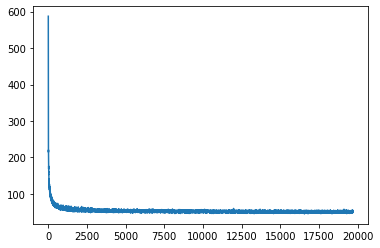

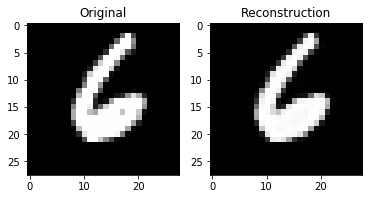

In [18]:
def main():
    X, Y = get_mnist()
    
    model = Autoencoder(784, 300)
    model.fit(X)
    
    #plot reconstruction 
    i = np.random.choice(len(X))
    x = X[i]
    im = model.predict([x]).reshape(28, 28)
    plt.subplot(1,2,1)
    plt.imshow(x.reshape(28,28), cmap='gray')
    plt.title("Original")
    plt.subplot(1,2,2)
    plt.imshow(im, cmap='gray')
    plt.title("Reconstruction")
    plt.show()
    
if __name__ == '__main__':
    main()